# Finding an object in an image using template matching

In this notebook, I demonstrate how template maching works and its limitations.

## Import packages

In [1]:
%matplotlib inline

import sys, math
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Open the image

In [2]:
test_image = cv2.imread("example1/cells.png", cv2.IMREAD_COLOR);

libpng warning: iCCP: CRC error


## Any error? Is the data loaded?

In [3]:
if test_image is None: 
    raise Exception("Could not open or find the image")

## Show the image

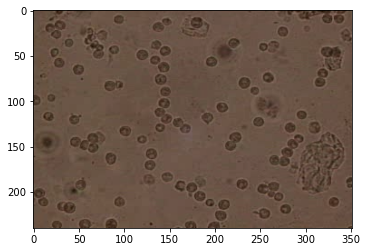

In [4]:
im_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB) # BGR to RGB
cv2.imshow("test_image", test_image)
plt.imshow(im_rgb)

## Open the template

In [5]:
template_image = cv2.imread("example1/template.jpg", cv2.IMREAD_COLOR)

## Any error? Is the data loaded?

In [6]:
if template_image is None: 
    raise Exception("Could not open or find the template")

## Show the template

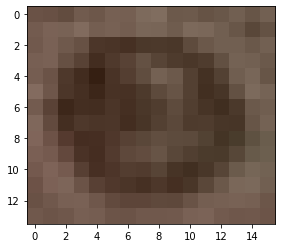

In [7]:
cv2.imshow("template_image", template_image)
im_rgb = cv2.cvtColor(template_image, cv2.COLOR_BGR2RGB) # BGR to RGB
plt.imshow(im_rgb)

## Convert to greyscale

In [8]:
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
template_image = cv2.cvtColor(template_image, cv2.COLOR_RGB2GRAY)

Write a function to apply the zero-mean, unit-variance normalisation

$Img_2(x,y) = \frac{Img_1(x,y) - \mathrm{avg}(Img_1)}{\mathrm{stddev}(Img_1)}$

In [9]:
def zeroMeanUnitVarianceNormalisation(anImage: np.array) -> np.array:
    
    # Convert to float (single-precision)
    tmp_image = anImage.astype(np.single)

    # Get the mean and standard deviation
    average = tmp_image.mean()
    stddev = tmp_image.std()

    return (tmp_image - average) / stddev

The average pixel value of `normalised_patch` is zero, the variance is 1.

In [10]:
normalised_template = zeroMeanUnitVarianceNormalisation(template_image)

Check the values

In [11]:
print("Min:", normalised_template.min())
print("Median:", np.median(normalised_template))
print("Mean:", normalised_template.mean())
print("Max:", normalised_template.max())
print("std:", normalised_template.std())

Min: -2.3519087
Median: 0.24382268
Mean: -1.1708055e-07
Max: 1.7270977
std: 0.99999994


The min value is negative, the mean is zero, the standard deviation is one.

## Compute the cross-correlation function

Create a new image of the right size

1. For every pixel location,
2. Extract the corresponding region of interest (ROI)
3. Transform it using the zero-mean, unit-variance normalisation
4. Perform a pixel-wise product between the two normalised patches
5. Compute its mean pixel value: It corresponds to the zero-mean normalised cross-correlation (ZNCC)
6. This is the auto-correlation value for that pixel location
7. The auto-correlation values are between -1 and 1.

In [12]:
autocorrelation_float = np.zeros(test_image.shape)
autocorrelation_uchar = 128 * np.ones(test_image.shape).astype(np.uint8)

cv2.namedWindow("Visualisation", cv2.WINDOW_KEEPRATIO)

# 1. For every pixel location,
for v in range(autocorrelation_float.shape[0] - template_image.shape[0]):

    for u in range(autocorrelation_float.shape[1] - template_image.shape[1]):
    
        # 2. Extract the corresponding region of interest (ROI)
        image_roi = test_image[v:v+template_image.shape[0], u:u+template_image.shape[1]]
        
        # 3. Transform it using the zero-mean, unit-variance normalisation
        normalised_image_roi = zeroMeanUnitVarianceNormalisation(image_roi)
        
        # 4. Perform a pixel-wise product between the two normalised patches
        # 5. Compute its mean pixel value
        average = np.mean(np.multiply(normalised_image_roi, normalised_template))

        # 6. This is the auto-correlation value for that pixel location
        x = round(u + template_image.shape[1] / 2)
        y = round(v + template_image.shape[0] / 2)
        autocorrelation_float[y,x] = average

        # Display an animation
        rescaled = math.floor(255.0 * ((average + 1) / 2.0))
        rescaled = max(0, rescaled)
        rescaled = min(255, rescaled)
                
        autocorrelation_uchar[y,x] = rescaled
        
        if not(u % 5) and not(v % 5):
            display_roi = np.copy(test_image)
            display_roi = cv2.rectangle(display_roi,
                      (u, v),
                      (u + template_image.shape[1], v + template_image.shape[0]),
                      (255, 255, 255), 2, 2, 0);

            vis = cv2.hconcat([display_roi, autocorrelation_uchar])
            cv2.imshow("Visualisation", vis)
            cv2.waitKey(1)

In [13]:
# 7. The auto-correlation values are between -1 and 1.
print(autocorrelation_float.min(), autocorrelation_float.max())

-0.5959168076515198 0.972947895526886


In [14]:
vis = cv2.hconcat([test_image, autocorrelation_uchar])
cv2.imshow("Visualisation", vis)
cv2.waitKey(0)

cv2.imwrite("example1/autocorrelation.png", ((autocorrelation_float + 1.0) / 2.0) * 255.0)

True

## Cross-correlation

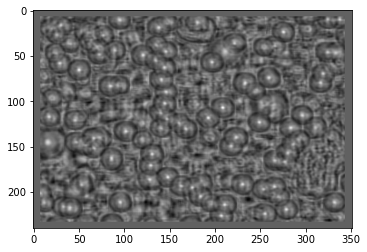

In [15]:
plt.imshow(autocorrelation_float, cmap="gray")

## Apply a threshold

In [16]:
binary_mask = cv2.threshold(autocorrelation_float,
          0.45,
          255,
          cv2.THRESH_BINARY)[1]

binary_mask = binary_mask.astype(np.uint8)
cv2.imwrite("example1/binary_mask.png", binary_mask);

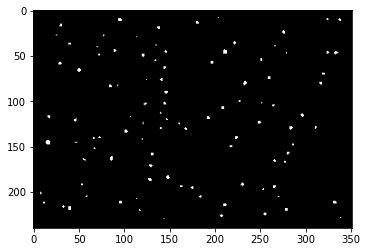

In [17]:
plt.imshow(binary_mask, cmap="gray")

## Find every island



In [18]:
contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours), "contours found")

101 contours found


## Draw the cells in random colours

In [19]:
image_contour = cv2.cvtColor(test_image, cv2.COLOR_GRAY2RGB)

for contour in contours:

    # Random colour in BGR
    colour = np.random.choice(range(256), size=3).tolist()

    cv2.drawContours(image_contour, [contour], 0, colour, 2, cv2.LINE_8, hierarchy, 0)
    
cv2.imwrite("example1/drawing.png", image_contour)
cv2.namedWindow("Contours", cv2.WINDOW_KEEPRATIO)
cv2.imshow( "Contours", image_contour )
cv2.waitKey(1)

-1

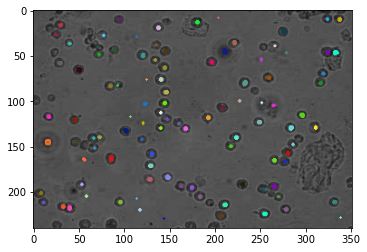

In [20]:
im_rgb = cv2.cvtColor(image_contour, cv2.COLOR_BGR2RGB) # BGR to RGB
plt.imshow(im_rgb)

In [21]:
cv2.waitKey(0)
cv2.destroyAllWindows()